## Import Library

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights, googlenet, GoogLeNet_Weights, vgg19, VGG19_Weights
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Preparation

In [ ]:
data_path='/content/drive/MyDrive/Colab Notebooks/Dataset'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir(data_path)

['gender_classification.csv',
 'class_identity.txt',
 'list_attribute.txt',
 'gender_classification.xlsx',
 'model_saved',
 'Images']

In [ ]:
images_list = sorted(os.listdir(data_path + '/Images'))

In [ ]:
# path to the attributes txt file
attr_path = os.path.join(data_path, 'list_attribute.txt')

# read all lines
with open(attr_path, 'r') as f:
    lines = f.readlines()

# attribute names (line 2)
attr_names = lines[1].strip().split()

# get index of 'Male' column
male_idx = attr_names.index('Male')

# parse only image names and 'Male' attribute
data_rows = []
for line in lines[2:]:
    parts = line.strip().split()
    filename = parts[0]
    male_attr = int(parts[male_idx + 1])  # +1 because the first item is the filename
    male_label = 1 if male_attr == 1 else 0  # Convert -1 to 0
    data_rows.append([filename, male_label])

# create a dataframe with just image and male columns
data = pd.DataFrame(data_rows, columns=['image', 'Male'])

# filter only images present in your folder
images_list = sorted(os.listdir(os.path.join(data_path, 'Images')))
images_list = [f for f in images_list if '(1)' not in f]
data = data[data['image'].isin(images_list)].reset_index(drop=True)

# check the dataframe
print(data.head())

        image  Male
0  000051.jpg     1
1  000052.jpg     1
2  000065.jpg     1
3  000166.jpg     1
4  000198.jpg     0


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5000 non-null   object
 1   Male    5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB
None


In [ ]:
'''
# load the data
data = pd.read_csv(os.path.join(data_path, 'gender_classification.csv')) # load data from file provided
images_list = [f for f in images_list if '(1)' not in f] # filter duplicate files with (1) in their filenames

# generate image filenames matching CSV rows (assuming CSV has 5000 rows and no image filename column)
num_rows = len(data)
generated_filenames = [f"{str(i+1).zfill(6)}.jpg" for i in range(num_rows)]
data['image'] = generated_filenames
data = data[['image', 'Male']] # reorder columns so image filename is the first column

data = data[data['image'].isin(images_list)].reset_index(drop=True) # filter the data with available images only (5000 images)
'''

'\n# load the data\ndata = pd.read_csv(os.path.join(data_path, \'gender_classification.csv\')) # load data from file provided\nimages_list = [f for f in images_list if \'(1)\' not in f] # filter duplicate files with (1) in their filenames\n\n# generate image filenames matching CSV rows (assuming CSV has 5000 rows and no image filename column)\nnum_rows = len(data)\ngenerated_filenames = [f"{str(i+1).zfill(6)}.jpg" for i in range(num_rows)]\ndata[\'image\'] = generated_filenames\ndata = data[[\'image\', \'Male\']] # reorder columns so image filename is the first column\n\ndata = data[data[\'image\'].isin(images_list)].reset_index(drop=True) # filter the data with available images only (5000 images)\n'

In [ ]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=3)

## Preprocessing

In [ ]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert("RGB")
        gender = self.data.iloc[idx, 1] # gender label is in column 1
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [ ]:
# transform pipeline for training dataset (with augmentation)
train_transform = transforms.Compose([
    # please define data transformation techniques here
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally (mirror image)
    transforms.RandomRotation(degrees=3),  # randomly rotate the image within 5 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # randomly change brightness and contrast (~20%)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform pipeline for validation/test dataset (no augmentation)
val_transform = transforms.Compose([
    # please define data transformation techniques here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=train_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, image_folder_path=os.path.join(data_path, "Images"), transform=val_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

## Architecture

In [ ]:
def get_model_and_optimizer(model_name, learning_rate=0.001, freeze_layers=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_name == 'resnet':
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        if freeze_layers:
            for param in model.parameters():
                param.requires_grad = False
        # Replace the final fully connected layer for 2 classes
        model.fc = nn.Linear(model.fc.in_features, 2)
        if freeze_layers:
            for param in model.fc.parameters():
                param.requires_grad = True

    elif model_name == 'vgg':
        model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        if freeze_layers:
            for param in model.parameters():
                param.requires_grad = False
        # Replace the last classifier layer (6th index)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
        if freeze_layers:
            for param in model.classifier[6].parameters():
                param.requires_grad = True

    elif model_name == 'googlenet':
        model = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
        if freeze_layers:
            for param in model.parameters():
                param.requires_grad = False
        # Replace the final fully connected layer
        model.fc = nn.Linear(model.fc.in_features, 2)
        if freeze_layers:
            for param in model.fc.parameters():
                param.requires_grad = True
    else:
        raise ValueError("Model name must be 'resnet', 'vgg', or 'googlenet'")

    # please define the model optimizer and criterion (loss function)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion

## Modeling

In [ ]:
import time

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # for storing metrics
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}\n" + "-" * 20)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                test_losses.append(epoch_loss)
                test_accs.append(epoch_acc.item())

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)

    # plotting after training
    epochs_range = range(1, num_epochs+1)

    plt.figure(figsize=(6,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train/Test Accuracy per Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train/Test Loss per Epoch')
    plt.legend()

    plt.show()

    return model

In [ ]:
dataloaders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

In [ ]:
use_gpu = torch.cuda.is_available()

Model Training

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


Epoch 1/7
--------------------
train Loss: 0.4509 Acc: 0.8117
test Loss: 0.2854 Acc: 0.9100
Epoch 2/7
--------------------
train Loss: 0.3049 Acc: 0.8820
test Loss: 0.2426 Acc: 0.9190
Epoch 3/7
--------------------
train Loss: 0.2674 Acc: 0.8978
test Loss: 0.2133 Acc: 0.9220
Epoch 4/7
--------------------
train Loss: 0.2490 Acc: 0.8998
test Loss: 0.2023 Acc: 0.9260
Epoch 5/7
--------------------
train Loss: 0.2452 Acc: 0.8988
test Loss: 0.1933 Acc: 0.9290
Epoch 6/7
--------------------
train Loss: 0.2271 Acc: 0.9120
test Loss: 0.1897 Acc: 0.9320
Epoch 7/7
--------------------
train Loss: 0.2279 Acc: 0.9110
test Loss: 0.1844 Acc: 0.9290

Training complete in 5m 39s
Best test Acc: 0.9320


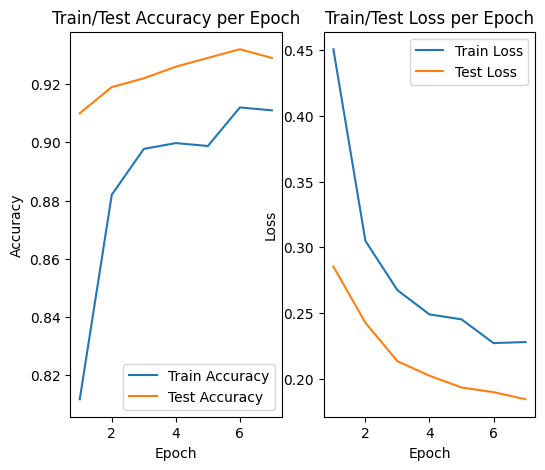

In [ ]:
# train using resnet with layers freezing and modified learning rate (the learning rate was originally 0.001)
resnet_model, resnet_optimizer, resnet_criterion = get_model_and_optimizer("resnet", learning_rate=0.0002, freeze_layers=True)
resnet_model = train_model(resnet_model, dataloaders, dataset_sizes, resnet_criterion, resnet_optimizer, use_gpu, num_epochs=7)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 151MB/s]


Epoch 1/7
--------------------
train Loss: 0.3400 Acc: 0.8565
test Loss: 0.2171 Acc: 0.9140
Epoch 2/7
--------------------
train Loss: 0.2498 Acc: 0.9002
test Loss: 0.2017 Acc: 0.9180
Epoch 3/7
--------------------
train Loss: 0.2404 Acc: 0.8985
test Loss: 0.1990 Acc: 0.9200
Epoch 4/7
--------------------
train Loss: 0.2393 Acc: 0.9038
test Loss: 0.1981 Acc: 0.9200
Epoch 5/7
--------------------
train Loss: 0.2228 Acc: 0.9080
test Loss: 0.1952 Acc: 0.9180
Epoch 6/7
--------------------
train Loss: 0.2239 Acc: 0.9048
test Loss: 0.2018 Acc: 0.9200
Epoch 7/7
--------------------
train Loss: 0.2256 Acc: 0.9093
test Loss: 0.1961 Acc: 0.9230

Training complete in 4m 35s
Best test Acc: 0.9230


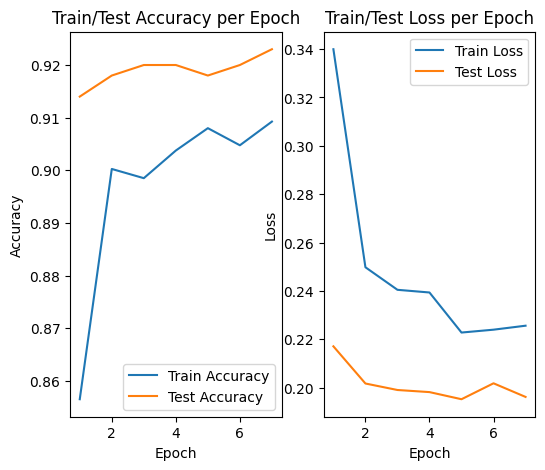

In [ ]:
# train using vgg with layers freezing and modified learning rate (the learning rate was originally 0.001)
vgg_model, vgg_optimizer, vgg_criterion = get_model_and_optimizer("vgg", learning_rate=0.0002, freeze_layers=True)
vgg_model = train_model(vgg_model, dataloaders, dataset_sizes, vgg_criterion, vgg_optimizer, use_gpu, num_epochs=7)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 181MB/s]


Epoch 1/7
--------------------
train Loss: 0.5338 Acc: 0.7722
test Loss: 0.3963 Acc: 0.8900
Epoch 2/7
--------------------
train Loss: 0.4089 Acc: 0.8518
test Loss: 0.3199 Acc: 0.9010
Epoch 3/7
--------------------
train Loss: 0.3553 Acc: 0.8702
test Loss: 0.2843 Acc: 0.9070
Epoch 4/7
--------------------
train Loss: 0.3299 Acc: 0.8725
test Loss: 0.2662 Acc: 0.9060
Epoch 5/7
--------------------
train Loss: 0.3143 Acc: 0.8802
test Loss: 0.2532 Acc: 0.9110
Epoch 6/7
--------------------
train Loss: 0.2960 Acc: 0.8885
test Loss: 0.2435 Acc: 0.9110
Epoch 7/7
--------------------
train Loss: 0.2905 Acc: 0.8788
test Loss: 0.2407 Acc: 0.9080

Training complete in 3m 32s
Best test Acc: 0.9110


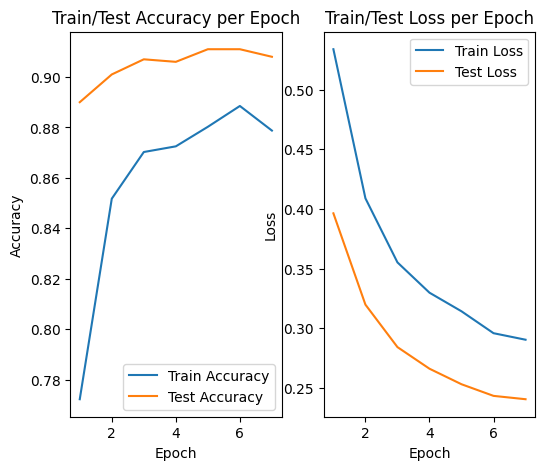

In [ ]:
# train using googlenet with layers freezing and modified learning rate (the learning rate was originally 0.001)
googlenet_model, googlenet_optimizer, googlenet_criterion = get_model_and_optimizer("googlenet", learning_rate=0.0002, freeze_layers=True)
googlenet_model = train_model(googlenet_model, dataloaders, dataset_sizes, googlenet_criterion, googlenet_optimizer, use_gpu, num_epochs=7)

## Evaluation

In [ ]:
def evaluate_model(model, test_loader, target_labels):
    # please define the evaluation function here
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_labels))

    # print overall accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {acc:.4f}\n")

    # plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_labels, yticklabels=target_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

      female       0.94      0.94      0.94       616
        male       0.91      0.90      0.91       384

    accuracy                           0.93      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000


Overall Accuracy: 0.9290



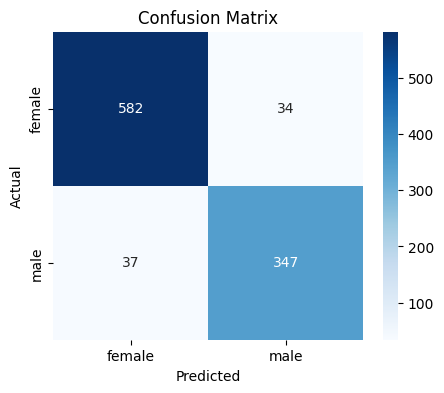

In [ ]:
# evaluate resnet model
evaluate_model(resnet_model, dataloaders['test'], ["female", "male"])

Classification Report:
              precision    recall  f1-score   support

      female       0.93      0.95      0.94       616
        male       0.91      0.88      0.90       384

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000


Overall Accuracy: 0.9230



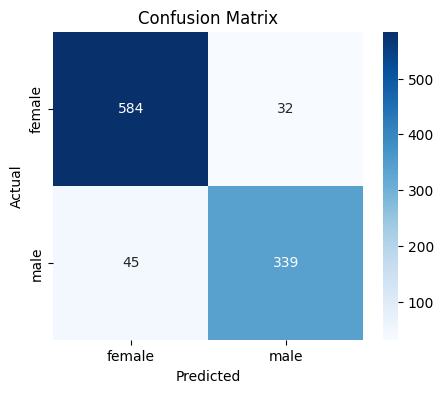

In [ ]:
# evaluate vgg model
evaluate_model(vgg_model, dataloaders['test'], ["female", "male"])

Classification Report:
              precision    recall  f1-score   support

      female       0.95      0.90      0.92       616
        male       0.85      0.93      0.89       384

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.91      0.91      0.91      1000


Overall Accuracy: 0.9080



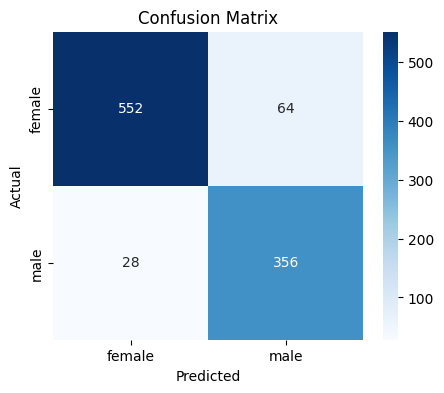

In [ ]:
# evaluate googlenet model
evaluate_model(googlenet_model, dataloaders['test'], ["female", "male"])

## Live Prediction

In [ ]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms
import io
import torch.nn.functional as F

def preprocess_image(image_bytes):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # resize for all models
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats

    ])
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    return preprocess(image).unsqueeze(0)  # add batch dimension

In [ ]:
def load_model_for_inference(model_name):
    model, _, _ = get_model_and_optimizer(model_name, freeze_layers=False)  # ensure all layers trainable for inference
    model.eval()
    return model

target_labels = ["female", "male"]

In [ ]:
def live_predict():
    print("Upload an image file (jpg, png)...")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded, aborting.")
        return

    image_filename = list(uploaded.keys())[0]
    image_bytes = uploaded[image_filename]

    model_name = input("Choose model to use (resnet, vgg, googlenet): ").lower()
    if model_name not in ["resnet", "vgg", "googlenet"]:
        print("Invalid model name. Please choose from 'resnet', 'vgg', or 'googlenet'.")
        return

    model = load_model_for_inference(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    input_tensor = preprocess_image(image_bytes).to(device)

    with torch.no_grad():
        start_time = time.time()
        outputs = model(input_tensor)
        inference_time = time.time() - start_time

        probs = F.softmax(outputs, dim=1)  # added to get probabilities
        conf, pred = torch.max(probs, 1)
        pred_label = target_labels[pred.item()]
        print(f"Prediction for {image_filename}: {pred_label} (Confidence: {conf.item():.4f})")
        print(f"Inference Time: {inference_time:.4f} seconds")

In [ ]:
live_predict()

Upload an image file (jpg, png)...


Saving 000414.jpg to 000414.jpg
Choose model to use (resnet, vgg, googlenet): vgg


NameError: name 'get_model_and_optimizer' is not defined

In [ ]:
!lscpu